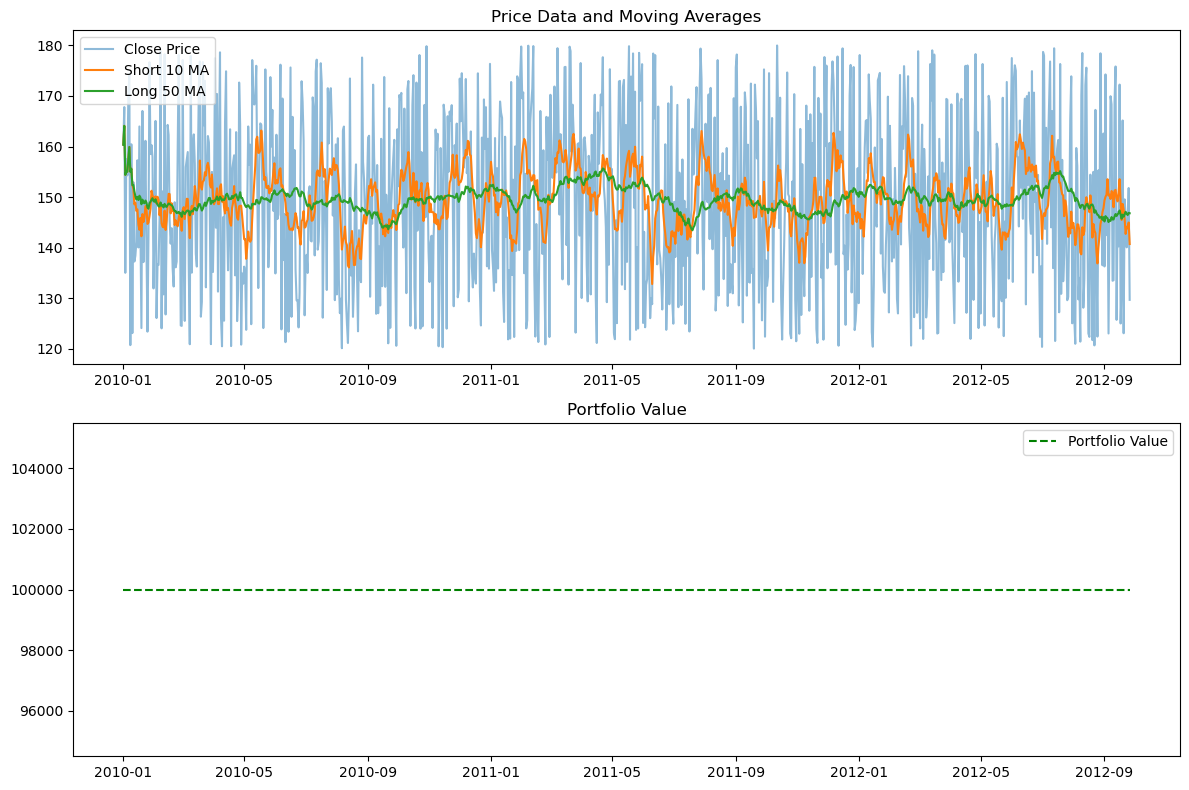

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulated historical price data
np.random.seed(42)  # For reproducibility
data = {
    'Date': pd.date_range(start='2010-01-01', periods=1000),
    'Open': np.random.uniform(100, 200, 1000),
    'High': np.random.uniform(200, 250, 1000),
    'Low': np.random.uniform(80, 150, 1000),
    'Close': np.random.uniform(120, 180, 1000),
    'Volume': np.random.randint(10000, 50000, 1000)
}

df = pd.DataFrame(data)
df.set_index('Date', inplace=True)

# Strategy function: Simple Moving Averages
def simple_moving_average_strategy(data, short_window, long_window):
    signals = pd.DataFrame(index=data.index)
    signals['Signal'] = 0.0  # Default to no signal

    # Compute Short and Long Moving Averages
    signals['Short_MA'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
    signals['Long_MA'] = data['Close'].rolling(window=long_window, min_periods=1).mean()

    # Buy signal when Short MA crosses above Long MA, and sell when it crosses below
    signals['Signal'] = np.where(signals['Short_MA'] > signals['Long_MA'], 1.0, -1.0)

    # Compute positions (1 = Buy, -1 = Sell)
    signals['Positions'] = signals['Signal'].diff().fillna(0)

    return signals

# Define strategy parameters
short_window = 10
long_window = 50

# Apply the strategy
signals = simple_moving_average_strategy(df, short_window, long_window)

# Risk Management Parameters
risk_per_trade = 0.02  # 2% of portfolio per trade
initial_portfolio_value = 100000  # Starting portfolio value
cash = initial_portfolio_value  # Cash on hand
position = 0  # Current position size
portfolio_value = []  # Store portfolio values over time

# Simulate trading
for index, row in signals.iterrows():
    close_price = df.loc[index, 'Close']
    low_price = df.loc[index, 'Low']

    # Calculate max position size based on 2% risk
    risk_amount = risk_per_trade * cash
    max_position_size = risk_amount / (close_price - low_price + 1e-8)  # Avoid div by 0

    # Buy or sell based on signals
    if row['Positions'] == 1 and cash >= close_price:  # Buy signal
        position = min(max_position_size, cash // close_price)
        cash -= position * close_price

    elif row['Positions'] == -1 and position > 0:  # Sell signal
        cash += position * close_price
        position = 0  # Clear position after selling

    # Track total portfolio value: cash + value of current position
    portfolio_value.append(cash + position * close_price)

# Store portfolio value in signals DataFrame
signals['PortfolioValue'] = portfolio_value

# Visualization of Results
plt.figure(figsize=(12, 8))

# Subplot 1: Price and Moving Averages
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], label='Close Price', alpha=0.5)
plt.plot(signals.index, signals['Short_MA'], label=f'Short {short_window} MA')
plt.plot(signals.index, signals['Long_MA'], label=f'Long {long_window} MA')
plt.legend()
plt.title('Price Data and Moving Averages')

# Subplot 2: Portfolio Value Over Time
plt.subplot(2, 1, 2)
plt.plot(signals.index, signals['PortfolioValue'], label='Portfolio Value', linestyle='--', color='green')
plt.legend()
plt.title('Portfolio Value')

plt.tight_layout()
plt.show()
